### Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH Библиотеки: [Python, Tensorflow]

In [1]:
%tensorflow_version 2.

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
import os
import cv2
import math
import glob
import scipy
import scipy.misc
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
!pip install scikit-video==1.1.11

     |████████████████████████████████| 2.3 MB 5.3 MB/s 


In [4]:
import skvideo.io

### датасет KTH

In [5]:
!wget http://www.nada.kth.se/cvap/actions/walking.zip
!wget http://www.nada.kth.se/cvap/actions/jogging.zip
!wget http://www.nada.kth.se/cvap/actions/running.zip
!wget http://www.nada.kth.se/cvap/actions/boxing.zip
!wget http://www.nada.kth.se/cvap/actions/handwaving.zip
!wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

!unzip walking.zip -d walking > /dev/null
!unzip jogging.zip -d jogging > /dev/null
!unzip running.zip -d running > /dev/null
!unzip boxing.zip -d boxing > /dev/null
!unzip handwaving.zip -d handwaving > /dev/null
!unzip handclapping.zip -d handclapping > /dev/null

--2021-10-29 22:55:44--  http://www.nada.kth.se/cvap/actions/walking.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2021-10-29 22:55:45--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M   965KB/s    in 4m 3s   

2021-10-29 22:59:49 (976 KB/s) - ‘walking.zip’ saved [242442411/242442411]

--2021-10-29 22:59:49--  http://www.nada.kth.se/cvap/actions/jogging.zip
Resolving www.nada.kth.se (www.nada.kth.s

### Подготовка датасета для классификации

In [6]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


### Разделим датасет на тренировочную и тестовую выборки.

In [7]:
random.shuffle(dataset)

test_count = math.floor(len(dataset)*0.4)

train_ds = dataset[:-test_count]
test_ds = dataset[-test_count:]

In [8]:
len(train_ds), len(test_ds)

(360, 239)

### Визуализация кадра из видео

In [9]:
dataset[0][0]

'./jogging/person22_jogging_d4_uncomp.avi'

videodata shape: (350, 120, 160, 3)
videodata shape: (120, 160, 3)


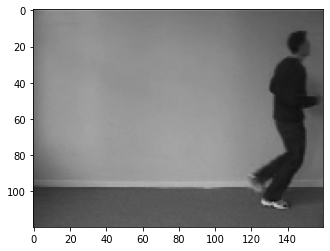

In [10]:
videodata = skvideo.io.vread(dataset[0][0]) 
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
print('videodata shape:', videodata[50, ...].shape)
plt.imshow(videodata[50, ...]) # 50-й кадр.

### Визуализация "движения"

motion shape: (117, 120, 160, 1)


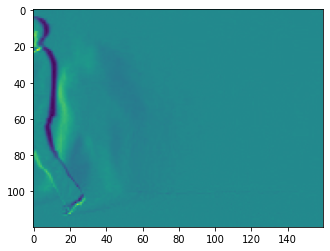

In [11]:
# Смещение изображения
motion = np.mean(videodata[0::3, ...] - videodata[1::3, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

### Создание модели CNN

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [13]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 117, 120, 160, 1)
Output shape: (1, 6)


### Подготовка к обучению

In [14]:
NUM_EPOCHS = 25
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

### Данные в модель будем подавать через генератор

In [15]:
def keras_generator(dataset, batch_size=1, frames=150, image_size=(80,60)):
    c = 0
    ind = np.arange(0, len(dataset))
    random.shuffle(ind)

    while True:
        X_batch = []
        y_batch = []
        for i in range(c, c + batch_size):

            img_path, label = dataset[i]
            videodata = skvideo.io.vread(img_path)
            videodata = videodata.astype(np.float32) / 255.
            # T, M, N, C = videodata.shape
            # steps = T//step
            step = 1
            steps = frames # для того чтобы видеоролики можно было объединить в batch. к-во кадров у них должно быть одинаковым.
            motion = []
            for s in range(steps):
                # if (s+4)*step > T:
                #     break
                frame_1 = cv2.resize(videodata[s*step], image_size)
                frame_2 = cv2.resize(videodata[(s+2)*step], image_size) # s+2 - это значить картинка смещена на два кадра.
                motion.append(np.mean((frame_1 - frame_2), axis=2, keepdims=True))

            X_batch.append(motion)
            y_batch.append(label)
            
        X_batch = np.array(X_batch, dtype='float')
        y_batch = np.array(y_batch, dtype='uint8')
        
        c += batch_size
        if(c + batch_size >= len(ind)):
            c = 0
            random.shuffle(ind)

        yield X_batch, y_batch

In [16]:
# создадим массив для проверки.
batch_size = 3
frames = 150 # видео объединяемые в батч должны иметь одинаковую продолжительность по кадрам.
target_img_size = (80,60) 

train_generator = keras_generator(train_ds, batch_size=batch_size,frames=frames, image_size=target_img_size)
test_generator = keras_generator(test_ds, batch_size=batch_size,frames=frames, image_size=target_img_size)

### Обучения модели

In [17]:
steps_per_epoch = len(train_ds)//batch_size
test_X, test_y = next(test_generator)
train_loss=[]
test_loss=[]

for epoch in range(NUM_EPOCHS):
    for iter in range(steps_per_epoch):

        train_X, train_y = next(train_generator)

        train_loss_value = model.train_on_batch(train_X, train_y)

        if iter % 10 == 0:
            test_loss_value = model.test_on_batch(test_X, test_y)

            test_loss.append(test_loss_value)
            train_loss.append(train_loss_value)

    print(f'[{epoch+1}/{NUM_EPOCHS}] loss: {train_loss_value}, val_loss: {test_loss_value}')

[1/25] loss: 0.7460831999778748, val_loss: 1.2311428785324097
[2/25] loss: 0.7846519351005554, val_loss: 0.5514116287231445
[3/25] loss: 1.4545539617538452, val_loss: 0.16789619624614716
[4/25] loss: 1.1967915296554565, val_loss: 0.5691214203834534
[5/25] loss: 2.417638063430786, val_loss: 0.05605541542172432
[6/25] loss: 0.10418552160263062, val_loss: 0.28035494685173035
[7/25] loss: 0.9318810105323792, val_loss: 0.1812431961297989
[8/25] loss: 0.038936372846364975, val_loss: 0.6030998229980469
[9/25] loss: 0.06440035253763199, val_loss: 0.6124370694160461
[10/25] loss: 0.15599583089351654, val_loss: 0.920738697052002
[11/25] loss: 0.07009033858776093, val_loss: 2.360252618789673
[12/25] loss: 0.39095282554626465, val_loss: 2.943143129348755
[13/25] loss: 0.0011026404099538922, val_loss: 0.6969429850578308
[14/25] loss: 4.247553806635551e-05, val_loss: 0.42967531085014343
[15/25] loss: 0.0071915495209395885, val_loss: 0.5366368889808655
[16/25] loss: 0.0002594997931737453, val_loss: 0

### график обучения

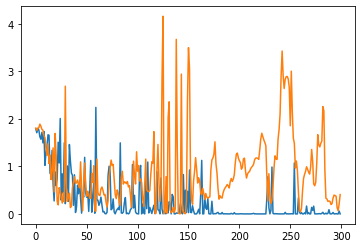

In [18]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

### Тестирование 

In [19]:
test_generator = keras_generator(test_ds, batch_size=1,frames=150, image_size=(80, 60))

In [22]:
def test_pred():
  fpath, cls_true = random.choice(dataset)

  videodata = skvideo.io.vread(fpath)
  videodata = videodata.astype(np.float32) / 255.
  plt.imshow(videodata[30, ...])

  motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

  out = model(motion[None, ...])[0]
  cls_pred = np.argmax(out.numpy())

  print('True class:', classes[cls_true])
  print('Predicted class:', classes[cls_pred])

In [21]:
print(classes)

['walking', 'jogging', 'running', 'boxing', 'handwaving', 'handclapping']


True class: jogging
Predicted class: jogging


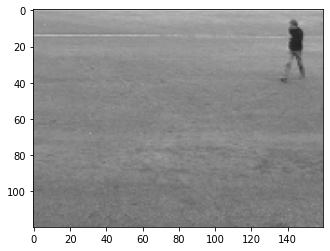

In [25]:
test_pred()

True class: walking
Predicted class: walking


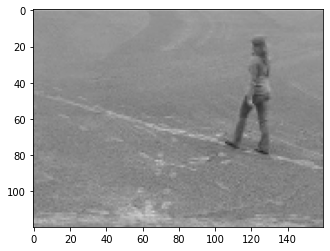

In [28]:
test_pred()

True class: running
Predicted class: running


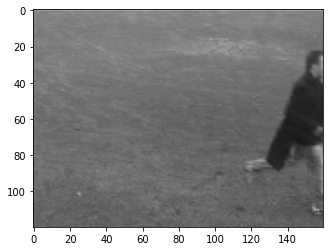

In [31]:
test_pred()

True class: walking
Predicted class: walking


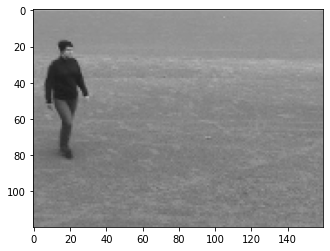

In [32]:
test_pred()

True class: running
Predicted class: running


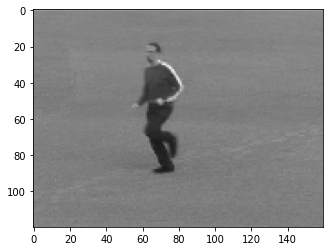

In [34]:
test_pred()

True class: boxing
Predicted class: handwaving


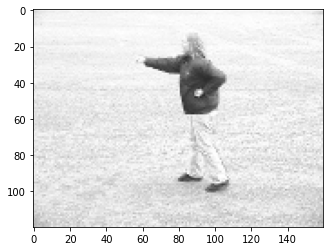

In [43]:
test_pred()